In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [2]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal("X", mu=0, sigma=1, shape=n, testval=-1.0 * np.ones_like(mu1))
    
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.75,0.75), NBfirstlayer=True, 
                             k_trunc=0.25)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.024
Stage:   3 Beta: 0.049
Stage:   4 Beta: 0.080
Stage:   5 Beta: 0.120
Stage:   6 Beta: 0.171
Stage:   7 Beta: 0.244
Stage:   8 Beta: 0.366
Stage:   9 Beta: 0.476
Stage:  10 Beta: 0.702
Stage:  11 Beta: 1.000


In [3]:
nf_evidence = trace.report.marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.003844920956576748
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.173  0.482  -0.689    0.633      0.011    0.008    1875.0  1875.0   
X[1] -0.180  0.484  -0.684    0.618      0.011    0.008    1926.0  1926.0   
X[2] -0.181  0.478  -0.682    0.624      0.011    0.008    1991.0  1830.0   
X[3] -0.169  0.477  -0.671    0.620      0.011    0.008    1949.0  1949.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1793.0    1382.0    NaN  
X[1]    2002.0    1881.0    NaN  
X[2]    1925.0    1823.0    NaN  
X[3]    1838.0    1865.0    NaN  


<Figure size 720x480 with 0 Axes>

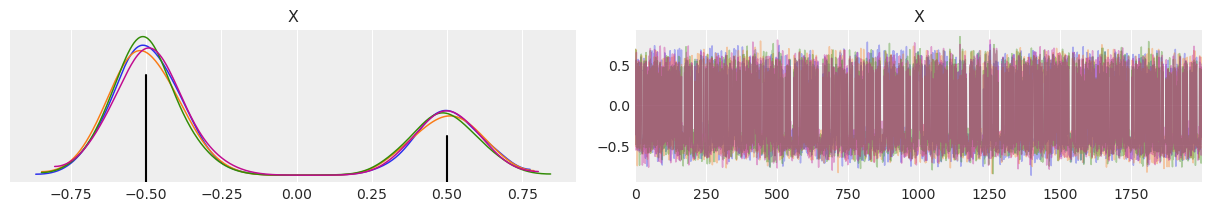

In [4]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

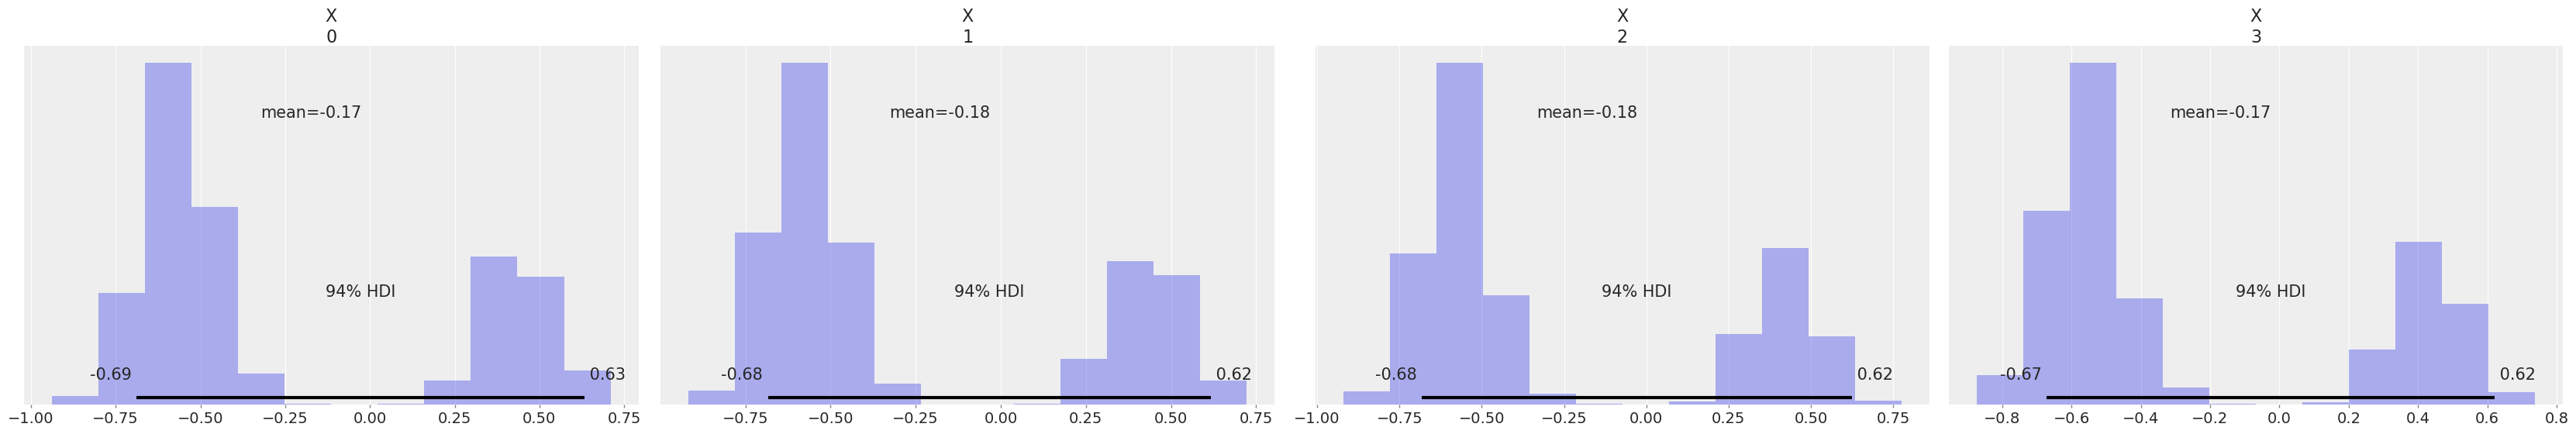

In [5]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

Let's just check what happens when I vary some of the SINF parameters.

In [6]:
with model:
    trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.5,0.5), NBfirstlayer=True, 
                             k_trunc=0.25)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.021
Stage:   3 Beta: 0.043
Stage:   4 Beta: 0.071
Stage:   5 Beta: 0.111
Stage:   6 Beta: 0.171
Stage:   7 Beta: 0.244
Stage:   8 Beta: 0.362
Stage:   9 Beta: 0.433
Stage:  10 Beta: 0.585
Stage:  11 Beta: 0.722
Stage:  12 Beta: 1.000


In [8]:
nf_evidence = trace.report.marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.0038520918772056655
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.198  0.474  -0.680    0.619      0.011    0.008    1983.0  1958.0   
X[1] -0.188  0.471  -0.682    0.632      0.011    0.008    1971.0  1911.0   
X[2] -0.196  0.474  -0.690    0.630      0.011    0.008    1936.0  1885.0   
X[3] -0.194  0.475  -0.680    0.631      0.011    0.008    1882.0  1862.0   

      ess_bulk  ess_tail  r_hat  
X[0]    2046.0    1923.0    NaN  
X[1]    1991.0    1728.0    NaN  
X[2]    1917.0    1825.0    NaN  
X[3]    1791.0    1883.0    NaN  


<Figure size 720x480 with 0 Axes>

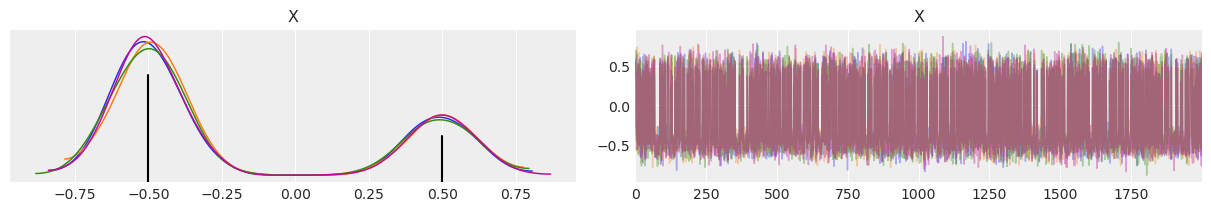

In [7]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

In [9]:
with model:
    trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.5,0.5), NBfirstlayer=True, 
                             k_trunc=0.5)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.025
Stage:   3 Beta: 0.054
Stage:   4 Beta: 0.082
Stage:   5 Beta: 0.143
Stage:   6 Beta: 0.185
Stage:   7 Beta: 0.293
Stage:   8 Beta: 0.417
Stage:   9 Beta: 0.619
Stage:  10 Beta: 0.668
Stage:  11 Beta: 0.970
Stage:  12 Beta: 1.000


In [10]:
nf_evidence = trace.report.marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.0038401233443169517
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.178  0.475  -0.698    0.619      0.011    0.008    1990.0  1770.0   
X[1] -0.176  0.481  -0.665    0.659      0.011    0.008    1971.0  1813.0   
X[2] -0.190  0.477  -0.690    0.604      0.011    0.008    1989.0  1897.0   
X[3] -0.184  0.476  -0.663    0.642      0.011    0.008    1960.0  1909.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1813.0    1881.0    NaN  
X[1]    2035.0    1862.0    NaN  
X[2]    1984.0    1915.0    NaN  
X[3]    1932.0    1655.0    NaN  


<Figure size 720x480 with 0 Axes>

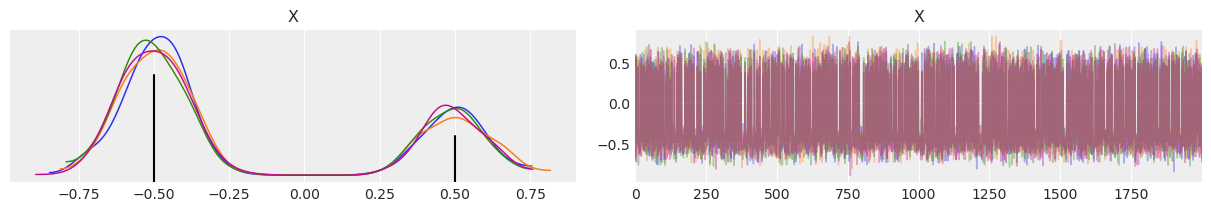

In [11]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

In [12]:
with model:
    trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.1, alpha=(0.5,0.5), NBfirstlayer=True, 
                             k_trunc=0.25)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.011
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.052
Stage:   4 Beta: 0.088
Stage:   5 Beta: 0.129
Stage:   6 Beta: 0.181
Stage:   7 Beta: 0.258
Stage:   8 Beta: 0.419
Stage:   9 Beta: 0.634
Stage:  10 Beta: 0.794
Stage:  11 Beta: 0.957
Stage:  12 Beta: 1.000


In [13]:
nf_evidence = trace.report.marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.003923983736896837
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.176  0.489  -0.710    0.622      0.013    0.009    1439.0  1439.0   
X[1] -0.171  0.482  -0.679    0.634      0.012    0.009    1569.0  1569.0   
X[2] -0.169  0.480  -0.684    0.625      0.012    0.009    1511.0  1511.0   
X[3] -0.173  0.484  -0.688    0.622      0.013    0.009    1482.0  1482.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1567.0    2026.0    NaN  
X[1]    1807.0    2003.0    NaN  
X[2]    1478.0    2045.0    NaN  
X[3]    1583.0    1888.0    NaN  


<Figure size 720x480 with 0 Axes>

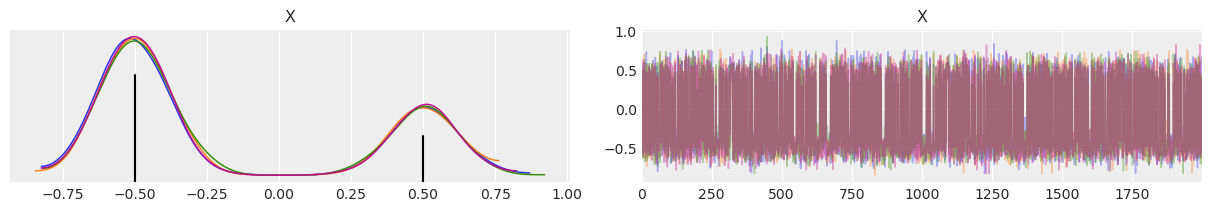

In [14]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

Let's compare with SMC. 

In [15]:
with model:
    smc_trace = pm.sample_smc(2000)
    az_smc_trace = az.from_pymc3(smc_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.143
Stage:   4 Beta: 0.309
Stage:   5 Beta: 0.658
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.143
Stage:   4 Beta: 0.308
Stage:   5 Beta: 0.645
Stage:   6 Beta: 1.000


In [16]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00335237 0.00359846]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.214  0.464  -0.685    0.610      0.007    0.005    3841.0  3841.0   
X[1] -0.209  0.464  -0.670    0.626      0.007    0.005    3883.0  3883.0   
X[2] -0.208  0.470  -0.680    0.624      0.008    0.005    3880.0  3849.0   
X[3] -0.210  0.466  -0.662    0.627      0.008    0.005    3854.0  3854.0   

      ess_bulk  ess_tail  r_hat  
X[0]    3838.0    3844.0    1.0  
X[1]    3710.0    4050.0    1.0  
X[2]    3839.0    3759.0    1.0  
X[3]    3843.0    3805.0    1.0  


<Figure size 720x480 with 0 Axes>

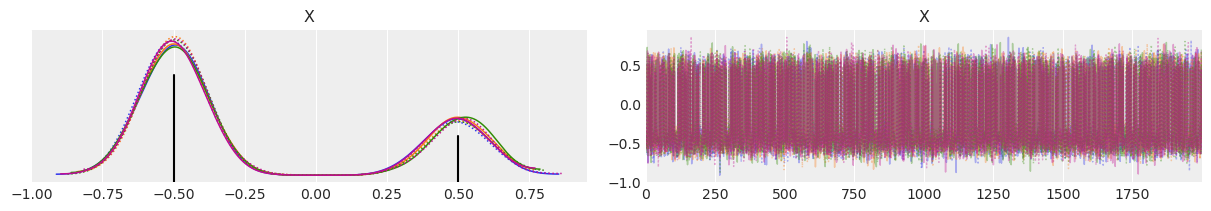

In [17]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

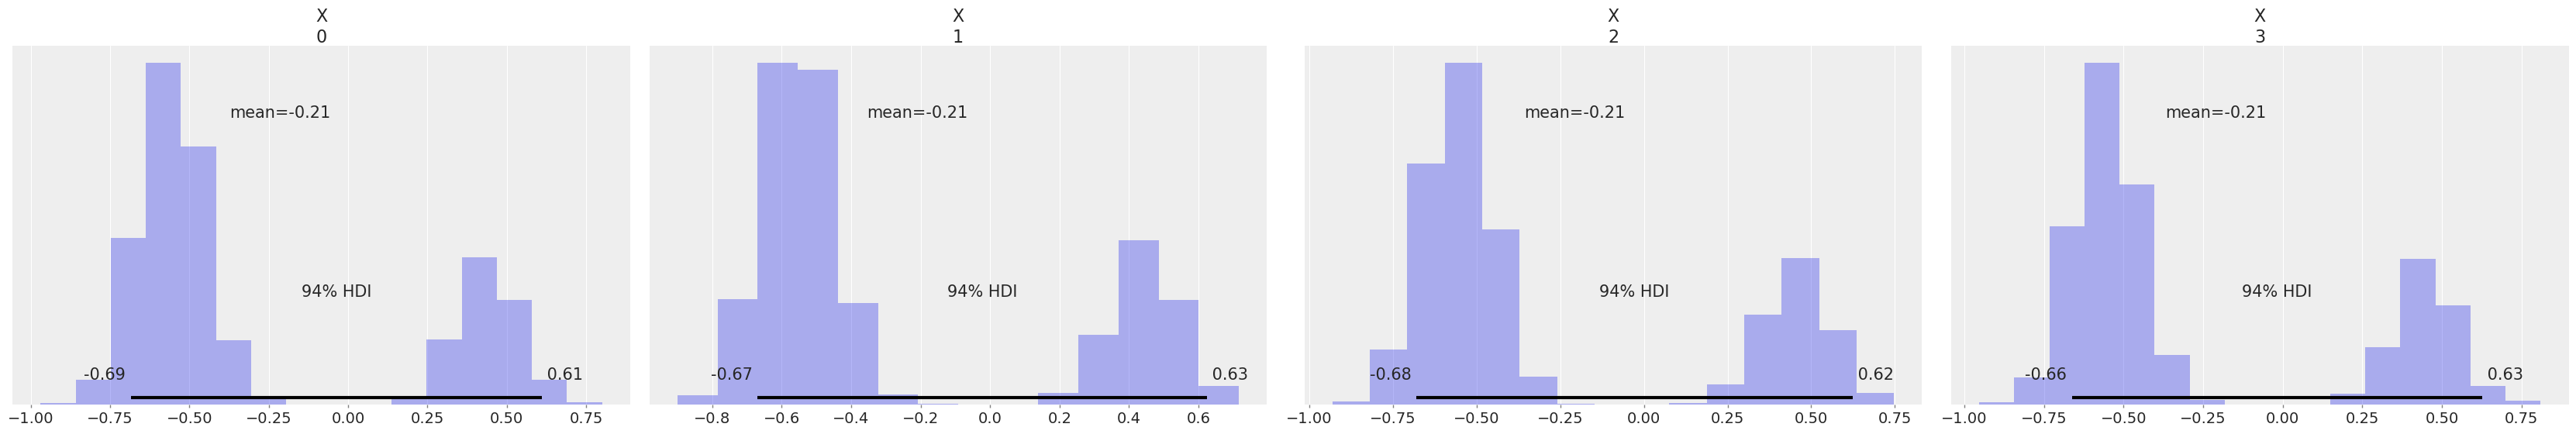

In [18]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

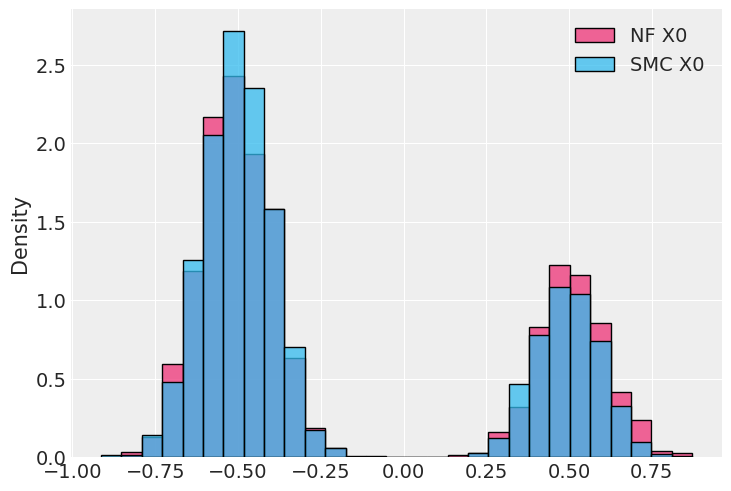

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


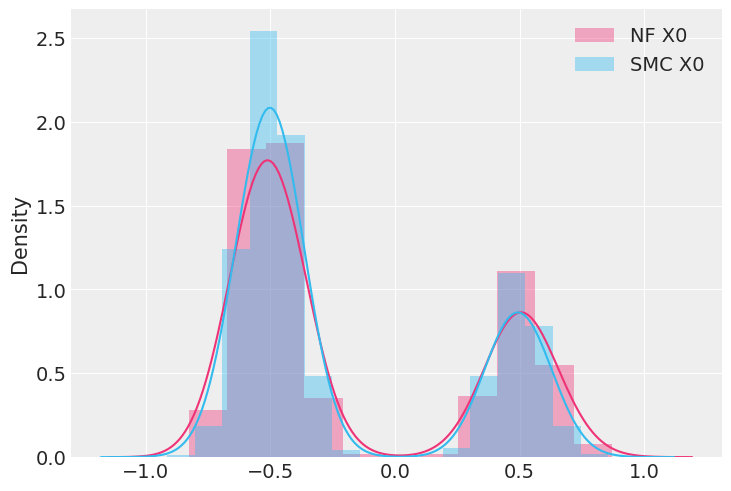

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [19]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 30)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
#plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x0, label='NF X0', color='#EE3377')
sns.distplot(smc_x0, label='SMC X0', color='#33BBEE')
#plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

'''
plt.figure()
sns.distplot(nf_x1, label='NF X1')
sns.distplot(smc_x1, label='SMC X1')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x2, label='NF X2')
sns.distplot(smc_x2, label='SMC X2')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x3, label='NF X3')
sns.distplot(smc_x3, label='SMC X3')
plt.legend(loc='upper right')
plt.show()
'''

In [20]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    rg_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.75,0.75), NBfirstlayer=True, 
                                epsilon=1e-3)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.007
Stage:   4 Beta: 0.021
Stage:   5 Beta: 0.052
Stage:   6 Beta: 0.139
Stage:   7 Beta: 0.349
Stage:   8 Beta: 0.880
Stage:   9 Beta: 1.000


<Figure size 720x480 with 0 Axes>

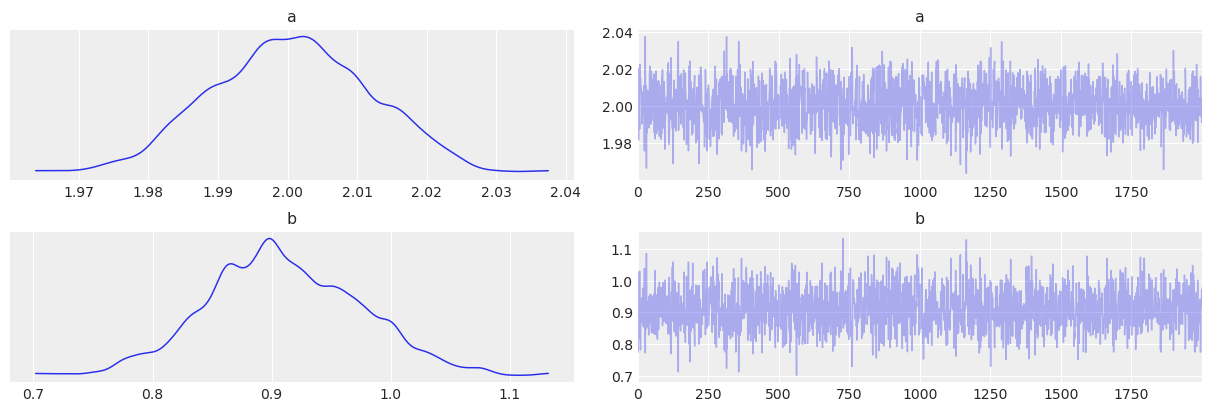

In [21]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [22]:
with rg_model:
    rg_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.5,0.5), NBfirstlayer=True, 
                                epsilon=1e-3)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.007
Stage:   4 Beta: 0.020
Stage:   5 Beta: 0.055
Stage:   6 Beta: 0.134
Stage:   7 Beta: 0.292
Stage:   8 Beta: 0.650
Stage:   9 Beta: 1.000


<Figure size 720x480 with 0 Axes>

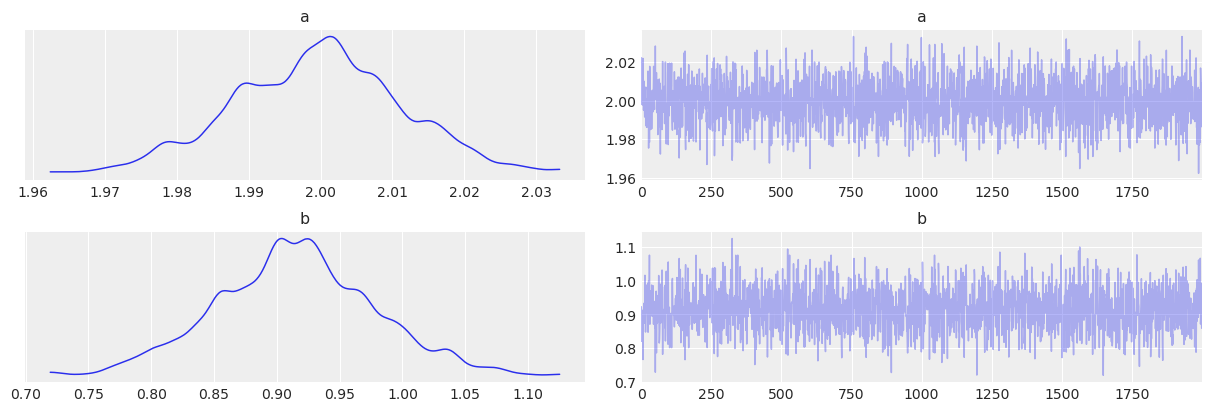

In [23]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [24]:
with rg_model:
    rg_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.5, alpha=(0.5,0.5), NBfirstlayer=True, 
                                epsilon=1e-3)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.007
Stage:   4 Beta: 0.024
Stage:   5 Beta: 0.059
Stage:   6 Beta: 0.136
Stage:   7 Beta: 0.313
Stage:   8 Beta: 0.679
Stage:   9 Beta: 1.000


<Figure size 720x480 with 0 Axes>

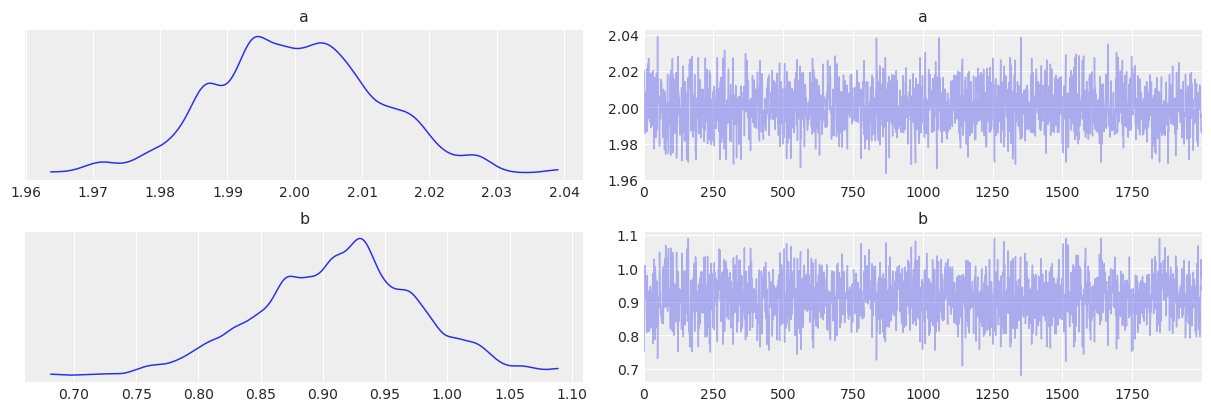

In [25]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [30]:
with rg_model:
    rg_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=None, NBfirstlayer=True, 
                                epsilon=1e-3)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.002
Stage:   3 Beta: 0.009
Stage:   4 Beta: 0.027
Stage:   5 Beta: 0.062
Stage:   6 Beta: 0.139
Stage:   7 Beta: 0.322
Stage:   8 Beta: 0.740
Stage:   9 Beta: 1.000


<Figure size 720x480 with 0 Axes>

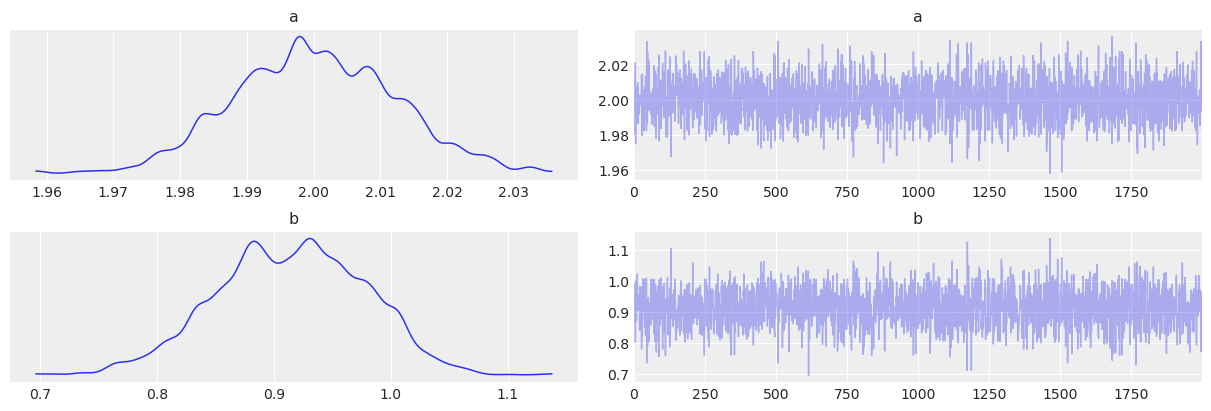

In [31]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [50]:
with rg_model:
    nuts_trace = pm.sample(2000)
    nuts_az_trace = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9001470797239908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953240491844467, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

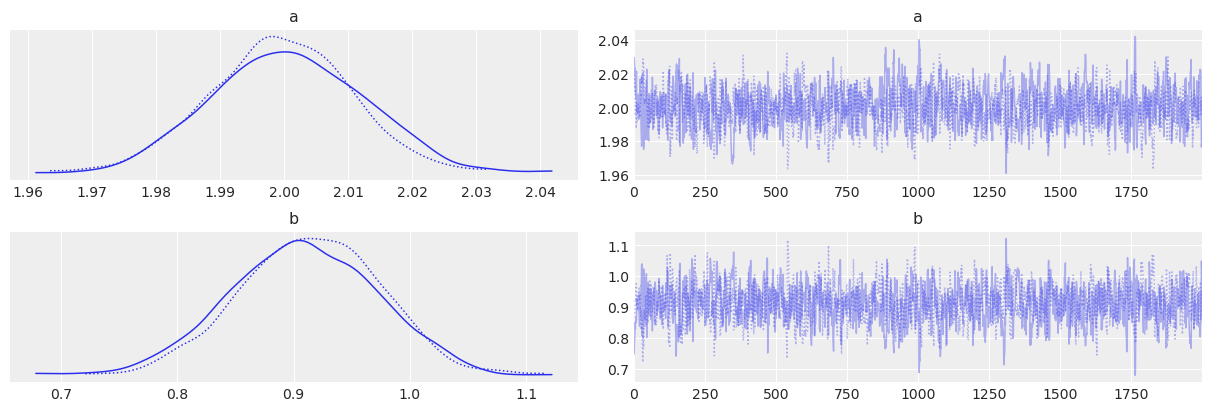

In [51]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

In [52]:
with rg_model:
    smc_rg_trace = pm.sample_smc(2000)
    az_smc_rg_trace = az.from_pymc3(smc_rg_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.009
Stage:   3 Beta: 0.035
Stage:   4 Beta: 0.125
Stage:   5 Beta: 0.426
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.112
Stage:   5 Beta: 0.401
Stage:   6 Beta: 1.000


<Figure size 720x480 with 0 Axes>

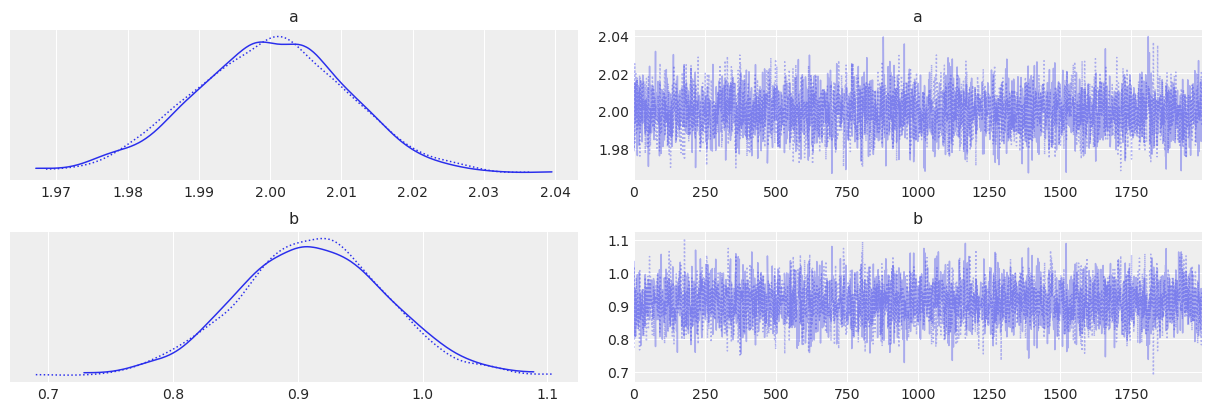

In [53]:
plt.figure()
az.plot_trace(az_smc_rg_trace)
plt.show()

In [54]:
smc_rg_evidence = np.exp(smc_rg_trace.report.log_marginal_likelihood)
print(f'SMC linear regression evidence: {smc_rg_evidence}')

SMC linear regression evidence: [393.58408597 348.07740838]


In [55]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(342.8375131717444, 1.4080725817074494e-05)


Hierarchical Radon Model ....

In [4]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [5]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [6]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.774077840116966, but should be close to 0.9. Try to increase the number of tuning steps.
There were 383 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

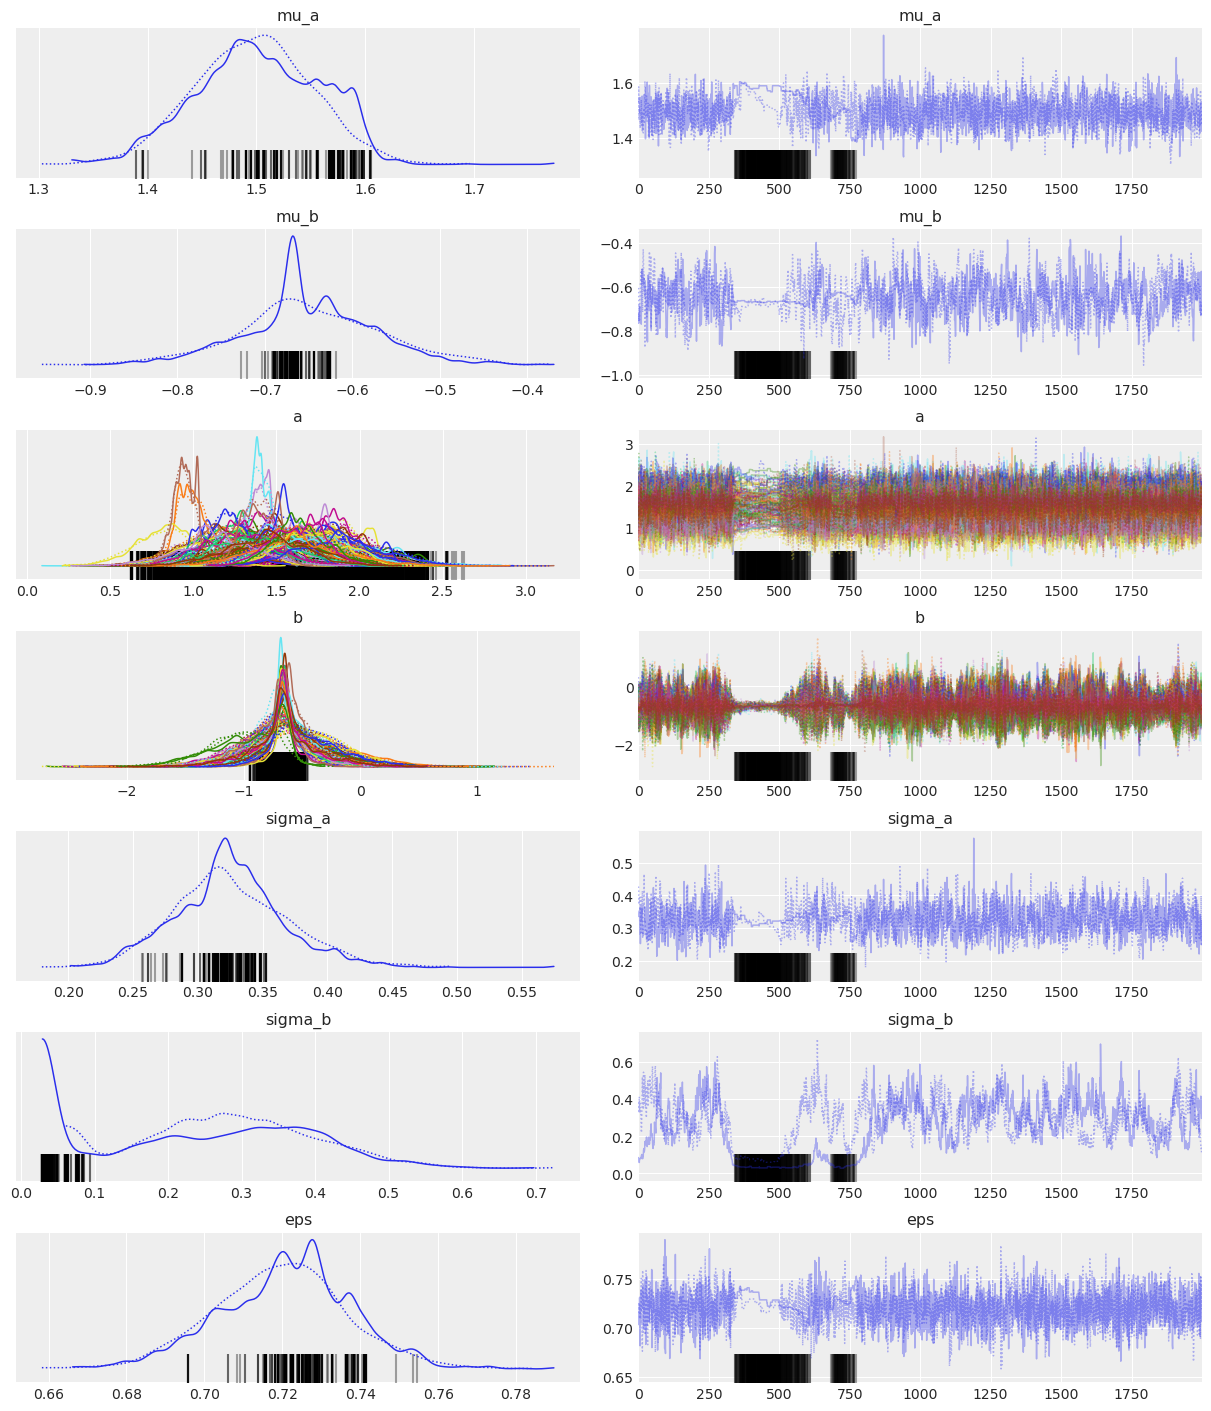

In [7]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [8]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nf_smc(500, chains=1, frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job


[-2.78901304e+05 -2.67661991e+04 -2.91114204e+04 -1.90387411e+05
 -2.96235644e+07 -4.89086668e+03 -3.40214695e+03 -1.16195067e+05
 -1.36832978e+06 -1.63012807e+07 -9.81602916e+04 -1.62208285e+05
 -1.52263929e+04 -2.36481492e+04 -8.89007503e+05 -4.60220524e+06
 -2.79967687e+05 -1.16679432e+04 -2.65904888e+04 -2.65915323e+04
 -1.79922351e+04 -2.28906768e+05 -1.86090067e+07 -5.98903061e+10
 -2.81775983e+05 -4.28101046e+04 -8.76923603e+04 -1.41538396e+08
 -2.35162524e+06 -2.13301427e+05 -2.21183172e+03 -5.15496146e+03
 -2.11255881e+03 -3.68479387e+03 -1.25774805e+05 -1.21178031e+05
 -4.06167371e+05 -2.25686267e+06 -1.43473336e+07 -1.01865515e+05
 -8.04000531e+08 -2.67519277e+05 -2.51499463e+05 -1.47231962e+04
 -3.15247195e+07 -2.31393889e+03 -1.79935733e+04 -1.99862278e+05
 -5.86200418e+07 -1.05860155e+04 -1.87427732e+07 -2.43340467e+04
 -2.91175352e+03 -8.58869219e+04 -2.37854659e+06 -4.14453266e+03
 -1.40338429e+04 -6.32162243e+04 -1.77068551e+03 -5.63740304e+03
 -3.48261798e+03 -2.38155

Stage:   0 Beta: 0.000


[-6.69031594e+00 -5.72849685e+00 -5.73744316e+00 -6.35266224e+00
 -1.18631322e+02 -5.64504908e+00 -5.63937006e+00 -6.06964091e+00
 -1.08461558e+01 -6.78108429e+01 -6.00084370e+00 -6.24516740e+00
 -5.68447598e+00 -5.71660243e+00 -9.01768639e+00 -2.31824117e+01
 -6.69438387e+00 -5.67090157e+00 -5.72782657e+00 -5.72783055e+00
 -5.69502683e+00 -6.49960192e+00 -7.66141188e+01 -2.28469013e+05
 -6.70128197e+00 -5.78969949e+00 -5.96091171e+00 -5.45552523e+02
 -1.45971303e+01 -6.44007227e+00 -5.63482937e+00 -5.64605652e+00
 -5.63445067e+00 -5.64044827e+00 -6.10618471e+00 -6.08864940e+00
 -7.17579746e+00 -1.42356398e+01 -6.03571262e+01 -6.01497800e+00
 -3.07264502e+03 -6.64689696e+00 -6.58578622e+00 -5.68255644e+00
 -1.25883653e+02 -5.63521888e+00 -5.69503194e+00 -6.38880599e+00
 -2.29244105e+02 -5.66677435e+00 -7.71243976e+01 -5.71921892e+00
 -5.63749936e+00 -5.95402451e+00 -1.46998271e+01 -5.64220204e+00
 -5.67992676e+00 -5.86754266e+00 -5.63314653e+00 -5.64789689e+00
 -5.63967703e+00 -6.53488

[-3.24923421e+03 -6.29422395e+03 -1.37529698e+04 -1.86944364e+17
 -1.48497164e+09 -2.04564380e+06 -2.42283404e+05 -4.97422280e+10
 -8.48309840e+03 -7.26711674e+06 -1.91346794e+04 -7.48621053e+06
 -2.34013346e+18 -3.52129746e+07 -1.34381839e+03 -5.32927806e+03
 -2.12844228e+03 -8.30518119e+03 -2.92436688e+05 -1.35607136e+06
 -1.54308529e+03 -7.16824601e+11 -2.43382931e+07 -2.91096882e+03
 -1.20176125e+04 -7.23519464e+08 -1.59770381e+04 -9.24872945e+03
 -2.97239168e+07 -1.67913872e+04 -1.42800999e+04 -6.06354390e+07
 -4.43045975e+03 -2.47118962e+03 -4.27292673e+03 -3.13930687e+03
 -8.90994810e+07 -7.36062726e+06 -2.08258473e+04 -2.33446333e+04
 -2.42138143e+04 -2.23536805e+03 -6.74353407e+03 -5.18842637e+05
 -1.20509052e+06 -2.30182521e+03 -5.38593479e+03 -3.07247153e+03
 -6.94849107e+03 -2.38161993e+03 -2.18159292e+07 -4.21587468e+09
 -1.03735963e+04 -2.07253467e+07 -1.57517788e+15 -7.42011536e+03
 -5.36000794e+05 -1.23075348e+09 -4.46933982e+05 -7.32227889e+03
 -1.95135497e+04 -2.97316

/home/richard/pymc3_dev/pymc3/nf_smc/nf_smc.py:190: RuntimeWarning: overflow encountered in exp
  ESS = int(np.exp(-logsumexp(log_weights_q + log_weights * 2)) / self.draws)


OverflowError: cannot convert float infinity to integer

In [ ]:
optim_iter=1000, nf_iter=20, 